## 타이타닉호 생존 예측
- 타이타닉 호의 생존자를 예측해보자
- 전통적인 문제이기 때문에 통계 검정 사용 x
- baseline 모델 비교(기본값의 성능이 가장 좋았던 모델에 optuna를 적용)

In [185]:
import pandas as pd

In [186]:
gender_df = pd.read_csv('gender_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [187]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Survived 생존(0 : 사망, 1: 생존)
- Pclass : 항공권 클래스
- name : 이름
- sex : 성별
- Age : 연령
- SibSp : 타이타닉에 승선한 형제자매/배우자
- Parch : 타이타닉호에 탑승한 부모/자녀
- ticket : 항공권 번호
- Fare : 여객 운임
- Cabin : 객실 번호
- Embarked : 승선항

In [188]:
train_df['Age'].median()

28.0

In [189]:
train_df.shape ## 891개의 데이터, 12개 컬럼

(891, 12)

In [190]:
train_df.isna().sum() # 결측치 확인

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


> Age 컬럼의 데이터의 결측치가 전체 값의 20% 이므로 중앙값으로 채우기

<Axes: xlabel='Survived', ylabel='count'>

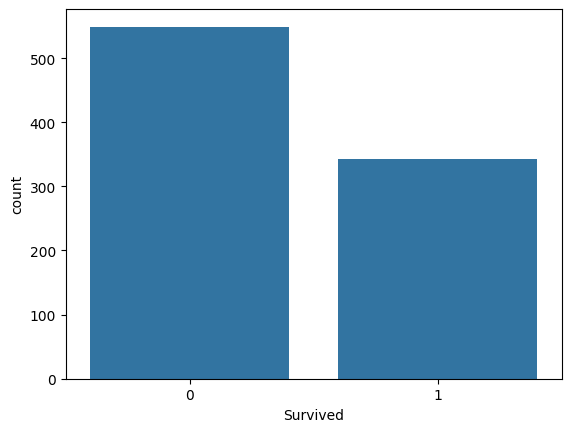

In [191]:
import seaborn as sns
sns.countplot(x='Survived', data = train_df)

In [192]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

In [193]:
train_df = train_df.drop('Cabin',axis=1)
test_df = test_df.drop('Cabin',axis=1)

In [194]:
test_df.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,1
Embarked,0


In [195]:
train_df['Embarked'].value_counts() # embarked 컬럼 값이 몇개씩 있는지

,count
Embarked,
S,644
C,168
Q,77


In [196]:
train_df['Embarked'] = train_df['Embarked'].fillna('S') # embarked 컬럼 결측값 S로 채워 넣기(S의 수가 가장 많음)
test_df['Embarked'] = test_df['Embarked'].fillna('S')

In [197]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [198]:
# passengerid , name, Ticket 컬럼 제거 입력피쳐에 적절하지 않음
train_df = train_df.drop(['PassengerId','Name','Ticket'],axis=1)
test_df = test_df.drop(['Name','Ticket'],axis=1)

In [199]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [200]:
test_df['Fare'] = test_df['Fare'].dropna()

In [201]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
train_df = pd.get_dummies(train_df,columns=['Sex','Embarked'],drop_first=True).astype(int)
#test_df = pd.get_dummies(test_df,columns=['Sex','Embarked'],drop_first=True).astype(int) #drop_first사용(첫번째 컬럼을 삭제해 다중 공선성 피하기 위함)
# get_dummies 함수 사용시 데이터 타입이 'bool' 정수형으로 바꿔줘야

In [202]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22,1,0,7,1,0,1
1,1,1,38,1,0,71,0,0,0
2,1,3,26,0,0,7,0,0,1
3,1,1,35,1,0,53,0,0,1
4,0,3,35,0,0,8,1,0,1


In [203]:
train_df['Sex_male'].dtypes

dtype('int64')

In [204]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [205]:
X = train_df.drop('Survived',axis=1) # 타겟피쳐 제거 후 특성, 타켓 분리
y = train_df['Survived']

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
#import lightgbm as lgb
from sklearn.metrics import accuracy_score
# 데이터 분할
X_train, X_val, y_train,y_val = train_test_split(X,y, test_size=0.2, random_state=2020158011)

models = {
    'random Forest' : RandomForestClassifier(random_state=2020158011,max_depth=6),
    'Decision Tree' : DecisionTreeClassifier(random_state=2020158011,max_depth=6),
    'Extra Tree' : ExtraTreesClassifier(random_state=2020158011,max_depth=6),
   #'Light GBM' :  lgb.LGBMClassifier(random_state=2020158011)
}
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  print(f'{name} accuracy : {accuracy_score(y_val, y_pred):.4f}')

random Forest accuracy : 0.8212
Decision Tree accuracy : 0.8156
Extra Tree accuracy : 0.8324


In [207]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [208]:
pred_model = ExtraTreesClassifier(random_state=2020158011, max_depth=6)
pred_model.fit(X,y)

ExtraTreesClassifier(max_depth=6, random_state=2020158011)

In [209]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [210]:
test_df['Fare'] = test_df['Fare'].fillna(0)

In [211]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
test_df = pd.get_dummies(test_df,columns=['Sex','Embarked'],drop_first=True).astype(int)

In [212]:
test_df['Fare'] = test_df['Fare'].fillna(0)

In [213]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Sex_male', 'Embarked_Q','Embarked_S']
X_test = test_df[features]
y_test_pred = pred_model.predict(X_test)

In [214]:
test_origin = pd.read_csv('test.csv')

In [215]:
'''
sub = pd.DataFrame({
    'PassengerId' : test_origin['PassengerId'],
    'Survived' : y_test_pred
})
'''

"\nsub = pd.DataFrame({\n    'PassengerId' : test_origin['PassengerId'],\n    'Survived' : y_test_pred\n})\n"

In [216]:
#sub.to_csv('submission.csv', index=False)

내일 할 일
- optuna 개념이해
- 생존자 예측
- 시각화(tableau or BI)

### optuna 이해하고 써보기

In [217]:
!pip install optuna

In [218]:
!pip install create_objective

ERROR: Could not find a version that satisfies the requirement create_objective (from versions: none)
ERROR: No matching distribution found for create_objective


In [219]:
%%writefile objective_function.py
import optuna
from sklearn.model_selection import cross_val_score

def create_objective(model_class, param_ranges, X_train, y_train, cv=5, scoring='accuracy'):
    def objective(trial):
        params = {}
        for param_name, param_config in param_ranges.items():
            if param_config['type'] == 'int':
                params[param_name] = trial.suggest_int(
                    param_name,
                    param_config['low'],
                    param_config['high'],
                    param_config.get('step', 1)
                )
            elif param_config['type'] == 'float':
                params[param_name] = trial.suggest_float(
                    param_name,
                    param_config['low'],
                    param_config['high'],
                    log=param_config.get('log', False)
                )
            elif param_config['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(
                    param_name,
                    param_config['choices']
                )
        model = model_class(**params)
        score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        return score.mean()
    return objective

Overwriting objective_function.py


### extra trees에 사용

In [220]:
from sklearn.ensemble import ExtraTreesClassifier
import optuna
# Extra Trees용 하이퍼파라미터 범위 정의
et_param_ranges = {
    'n_estimators': {'type': 'int', 'low': 50, 'high': 100},
    'max_depth': {'type': 'int', 'low': 5, 'high': 30},
    'min_samples_split': {'type': 'int', 'low': 2, 'high': 20},
    'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 10},
    'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]},
    'bootstrap': {'type': 'categorical', 'choices': [True, False]}
}

# objective 함수 생성
from objective_function import create_objective
et_objective = create_objective(ExtraTreesClassifier, et_param_ranges, X_train, y_train)

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(et_objective, n_trials=50)

[I 2025-07-14 03:20:23,508] A new study created in memory with name: no-name-b5d0caa1-de53-4fa4-addd-57105b30d6eb
/content/objective_function.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  params[param_name] = trial.suggest_int(
[I 2025-07-14 03:20:24,994] Trial 0 finished with value: 0.8202403230572244 and parameters: {'n_estimators': 88, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8202403230572244.
/content/objective_function.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but t

In [221]:
best_params = study.best_params
print(best_params)

{'n_estimators': 56, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}


최적의 하이퍼 파라미터
n_estimators : 93       
max_depth : 13
min_samples_split : 6
min_samples_leaf : 2
max_features : log2
bootstrap: False

In [222]:
from sklearn.ensemble import ExtraTreesClassifier as etc

best_model = etc(**best_params) # 딕셔너리언패킹
best_model.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=26, max_features='log2', min_samples_leaf=2,
                     min_samples_split=6, n_estimators=56)

In [223]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,34,0,0,7,1,1,0
1,893,3,47,1,0,7,0,0,1
2,894,2,62,0,0,9,1,1,0
3,895,3,27,0,0,8,1,0,1
4,896,3,22,1,1,12,0,0,1


In [224]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22,1,0,7,1,0,1
1,1,1,38,1,0,71,0,0,0
2,1,3,26,0,0,7,0,0,1
3,1,1,35,1,0,53,0,0,1
4,0,3,35,0,0,8,1,0,1


In [225]:
print(f'train_df:{train_df.shape}')
print(f'test_df:{test_df.shape}')

train_df:(891, 9)
test_df:(418, 9)


In [226]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,34,0,0,7,1,1,0
1,893,3,47,1,0,7,0,0,1
2,894,2,62,0,0,9,1,1,0
3,895,3,27,0,0,8,1,0,1
4,896,3,22,1,1,12,0,0,1


### 예측 수행 후 csv 파일 저장

In [227]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Sex_male', 'Embarked_Q','Embarked_S']
X_test =  test_df[features]
y_test_pred = best_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId' : test_df['PassengerId'],
    'Survived' : y_test_pred
})

submission.to_csv('submission.csv', index = False)

In [229]:
y_test.shape

(891, 8)

In [230]:
y_pred.shape

(179,)

In [236]:
submission_df = pd.read_csv('submission.csv')
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### XGBoost trees에 *사용*

In [ ]:
from xgboost import XGBClassifier

# XGBoost용 하이퍼파라미터 범위 정의
xgb_param_ranges = {
    'n_estimators': {'type': 'int', 'low': 50, 'high': 500},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.3, 'log': True},
    'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0},
    'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 1.0},
    'gamma': {'type': 'float', 'low': 0, 'high': 5}
}

# objective 함수 생성
xgb_objective = create_objective(XGBClassifier, xgb_param_ranges, X_train, y_train)

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=50) #초기탐색용도

### 로지스틱 회귀에 사용

In [ ]:
'''from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀용 하이퍼파라미터 범위 정의
lr_param_ranges = {
    'C': {'type': 'float', 'low': 0.001, 'high': 100, 'log': True},
    'penalty': {'type': 'categorical', 'choices': ['l1', 'l2', 'elasticnet', None]},
    'solver': {'type': 'categorical', 'choices': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
}

# objective 함수 생성
lr_objective = create_objective(LogisticRegression, lr_param_ranges, X_train, y_train)

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(lr_objective, n_trials=50)
'''